In [ ]:
%%capture
#BAYES
!pip install bnlearn
#RDKIT
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
from rdkit.Chem import PandasTools
import pandas as pd
import os
from rdkit import RDConfig

# sdfFile = os.path.join(RDConfig.RDDataDir,'/content/nr-ar.sdf')
sdfFile = os.path.join(RDConfig.RDDataDir,'/content/drive/MyDrive/bayes-konf-06-22/tox21.sdf') 
frame = PandasTools.LoadSDF(sdfFile, smilesName='SMILES', molColName='Molecule',
           includeFingerprints=True)
print(frame.columns)
print(frame.shape)

Index(['Formula', 'FW', 'DSSTox_CID', 'SR-HSE', 'ID', 'SMILES', 'Molecule',
       'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'],
      dtype='object')
(11761, 18)


In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

nBITS = 1024
fps = []
for index, row in frame.iterrows():
  fp = AllChem.GetMorganFingerprintAsBitVect(row['Molecule'],3,nBits=nBITS)
  arr = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(fp,arr)
  fps.append(arr)

In [ ]:
features_tox = ['NR-AR', 'NR-AR-LBD']
data = pd.concat([frame[features_tox], pd.DataFrame(fps)], axis=1)
data.dropna(subset=range(0,nBITS), how='any', inplace=True)
print(data.columns)
print(data.shape)

Index([    'NR-AR', 'NR-AR-LBD',           0,           1,           2,
                 3,           4,           5,           6,           7,
       ...
              1014,        1015,        1016,        1017,        1018,
              1019,        1020,        1021,        1022,        1023],
      dtype='object', length=1026)
(11761, 1026)


In [ ]:
import bnlearn as bn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# DAG = bn.structure_learning.fit(data) # Learn the DAG in data using Bayesian structure learning
data_cur = data.dropna()
# data_cur = data.dropna(subset=features_tox, how='all')
# upper_tri = data_cur.corr().abs().where(np.triu(np.ones(data_cur.corr().abs().shape),k=1).astype(np.bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
# data_cur_ncor = data_cur.drop(data_cur.columns[to_drop], axis=1)
# data_cur_ncor = data_cur.T.drop_duplicates().T

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample

# X_train, X_test, y_train, y_test = train_test_split(data_cur_ncor.drop(features_tox, axis=1), data_cur_ncor[features_tox], test_size=0.2, stratify=data_cur_ncor[features_tox])

datas_down_cur = []
for i, _ in enumerate(features_tox):
  df_0 = data_cur[data_cur[features_tox[i]] != '1']
  df_1 = data_cur[data_cur[features_tox[i]] == '1']  
  df_0_down = resample(df_0,random_state=42,n_samples=len(df_1),replace=True)
  data_down_cur = pd.concat([df_0_down,df_1])
  datas_down_cur.append(data_down_cur)

for i in range(len(datas_down_cur)-1):
  if i == 0:
    data_down_cur = pd.concat([datas_down_cur[i],datas_down_cur[i+1]])
  else:
    data_down_cur = pd.concat([data_down_cur,datas_down_cur[i+1]])

X_train, X_test, y_train, y_test = train_test_split(data_down_cur.drop(features_tox, axis=1), data_down_cur[features_tox], test_size=0.2)


selected_fea = []
for i, _ in enumerate(features_tox):
  select_fea = SelectKBest(k=6,
                          score_func=mutual_info_classif,
                          ).fit(X_train, y_train.loc[:, features_tox[i]])
  # X_train = select_fea.transform(X_train)
  selected = select_fea.get_feature_names_out()
  selected = [e[1:] for e in selected]
  selected_fea.extend(selected)
selected_fea = list(set(selected_fea))
X_train = X_train.loc[:, map(int, selected_fea)]
print(selected_fea)

['250', '301', '138', '519', '714', '529', '412', '622']


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from statistics import mean

dfx, dft = pd.DataFrame(X_train), pd.DataFrame(y_train)
dft.index = dfx.index
train = pd.concat([dfx, dft], axis=1)
train.columns = [*selected_fea, *features_tox]
train.reset_index(inplace=True, drop=True)

SPLITS = 5
kf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)
DAG = bn.structure_learning.fit(train, 
                                methodtype='hc', fixed_edges=[(features_tox[0], features_tox[1])]
                                # methodtype='tan', class_node=features_tox[0]
                                # methodtype='cl', root_node=features_tox[0]
                                # methodtype='cs' #or 'ex'
                                )
# print(DAG['adjmat']) # print adjacency matrix

used_params = list({item for sublist in DAG['model_edges'] for item in sublist})
train = train.loc[:, used_params]

acc, bac, auc, pre, rec = [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox), [[None]*SPLITS]*len(features_tox)

split_i = 0
for train_index, test_index in kf.split(train):
  DAGp = bn.parameter_learning.fit(DAG, train.loc[train_index, :])
  Pout = bn.predict(DAGp, train.loc[test_index, :], variables=features_tox)
  y_pred = Pout[features_tox]
  for i, _ in enumerate(features_tox):
    # acc[i], bac[i], auc[i], pre[i], rec[i] = [], [], [], [], []
    acc[i][split_i] = round(accuracy_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    bac[i][split_i] = round(balanced_accuracy_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    auc[i][split_i] = round(roc_auc_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    pre[i][split_i] = round(precision_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
    rec[i][split_i] = round(recall_score(train.loc[test_index, features_tox[i]].astype(int), y_pred[features_tox[i]]), 4)
  split_i += 1

for i, (c,b,a,p,r) in enumerate(zip(acc, bac, auc, pre, rec)): 
  print(f''' 
  Feature no. {i}
  ACC: {c}, mean: {round(mean(c), 4)}
  BAC: {b}, mean: {round(mean(b), 4)}
  AUC: {a}, mean: {round(mean(a), 4)}
  PRE: {p}, mean: {round(mean(p), 4)}
  REC: {r}, mean: {round(mean(r), 4)}
  ''')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 250:
+-----------+---------------------+-----+---------------------+
| 138       | 138(0.0)            | ... | 138(1.0)            |
+-----------+---------------------+-----+---------------------+
| 519       | 519(0.0)            | ... | 519(1.0)            |
+-----------+---------------------+-----+---------------------+
| NR-AR-LBD | NR-AR-LBD(0)        | ... | NR-AR-LBD(1)        |
+-----------+---------------------+-----+---------------------+
| 250(0.0)  | 0.8282918149466192  | ... | 0.28775510204081634 |
+-----------+---------------------+-----+---------------------+
| 250(1.0)  | 0.17170818505338079 | ... | 0.7122448979591837  |
+-----------+---------------------+-----+---------------------+
[bnlearn] >CPD of 412:
+----------+---------------------+-----+--------------

100%|██████████| 32/32 [00:01<00:00, 25.83it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 250:
+-----------+-------------------+-----+---------------------+
| 138       | 138(0.0)          | ... | 138(1.0)            |
+-----------+-------------------+-----+---------------------+
| 519       | 519(0.0)          | ... | 519(1.0)            |
+-----------+-------------------+-----+---------------------+
| NR-AR-LBD | NR-AR-LBD(0)      | ... | NR-AR-LBD(1)        |
+-----------+-------------------+-----+---------------------+
| 250(0.0)  | 0.828397212543554 | ... | 0.29065040650406504 |
+-----------+-------------------+-----+---------------------+
| 250(1.0)  | 0.171602787456446 | ... | 0.709349593495935   |
+-----------+-------------------+-----+---------------------+
[bnlearn] >CPD of 412:
+----------+---------------------+-----+---------------------+
| 250      | 250(0.0)            | ... | 250(1.0)            |
+----------+----------------

100%|██████████| 28/28 [00:01<00:00, 24.37it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 250:
+-----------+---------------------+-----+--------------------+
| 138       | 138(0.0)            | ... | 138(1.0)           |
+-----------+---------------------+-----+--------------------+
| 519       | 519(0.0)            | ... | 519(1.0)           |
+-----------+---------------------+-----+--------------------+
| NR-AR-LBD | NR-AR-LBD(0)        | ... | NR-AR-LBD(1)       |
+-----------+---------------------+-----+--------------------+
| 250(0.0)  | 0.8324829931972789  | ... | 0.2974683544303797 |
+-----------+---------------------+-----+--------------------+
| 250(1.0)  | 0.16751700680272108 | ... | 0.7025316455696202 |
+-----------+---------------------+-----+--------------------+
[bnlearn] >CPD of 412:
+----------+---------------------+-----+---------------------+
| 250      | 250(0.0)            | ... | 250(1.0)            |
+----------+-----

100%|██████████| 31/31 [00:01<00:00, 25.47it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 250:
+-----------+---------------------+-----+--------------------+
| 138       | 138(0.0)            | ... | 138(1.0)           |
+-----------+---------------------+-----+--------------------+
| 519       | 519(0.0)            | ... | 519(1.0)           |
+-----------+---------------------+-----+--------------------+
| NR-AR-LBD | NR-AR-LBD(0)        | ... | NR-AR-LBD(1)       |
+-----------+---------------------+-----+--------------------+
| 250(0.0)  | 0.84412265758092    | ... | 0.2957446808510638 |
+-----------+---------------------+-----+--------------------+
| 250(1.0)  | 0.15587734241908008 | ... | 0.7042553191489361 |
+-----------+---------------------+-----+--------------------+
[bnlearn] >CPD of 412:
+----------+---------------------+-----+---------------------+
| 250      | 250(0.0)            | ... | 250(1.0)            |
+----------+-----

100%|██████████| 33/33 [00:01<00:00, 25.32it/s]


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianNetwork.
[bnlearn] >CPD of 250:
+-----------+---------------------+-----+---------------------+
| 138       | 138(0.0)            | ... | 138(1.0)            |
+-----------+---------------------+-----+---------------------+
| 519       | 519(0.0)            | ... | 519(1.0)            |
+-----------+---------------------+-----+---------------------+
| NR-AR-LBD | NR-AR-LBD(0)        | ... | NR-AR-LBD(1)        |
+-----------+---------------------+-----+---------------------+
| 250(0.0)  | 0.8336236933797909  | ... | 0.29132231404958675 |
+-----------+---------------------+-----+---------------------+
| 250(1.0)  | 0.16637630662020905 | ... | 0.7086776859504132  |
+-----------+---------------------+-----+---------------------+
[bnlearn] >CPD of 412:
+----------+---------------------+-----+--------------------+
| 250      | 250(0.0)            | ... | 250(1.0)           |
+-------

100%|██████████| 33/33 [00:01<00:00, 25.96it/s]

 
  Feature no. 0
  ACC: [0.8039, 0.7537, 0.7635, 0.7537, 0.7586], mean: 0.7667
  BAC: [0.7365, 0.6906, 0.7333, 0.729, 0.7092], mean: 0.7197
  AUC: [0.7365, 0.6906, 0.7333, 0.729, 0.7092], mean: 0.7197
  PRE: [0.7826, 0.7556, 0.8519, 0.8545, 0.7358], mean: 0.7961
  REC: [0.5455, 0.4658, 0.5349, 0.5281, 0.527], mean: 0.5203
  
 
  Feature no. 1
  ACC: [0.8039, 0.7537, 0.7635, 0.7537, 0.7586], mean: 0.7667
  BAC: [0.7365, 0.6906, 0.7333, 0.729, 0.7092], mean: 0.7197
  AUC: [0.7365, 0.6906, 0.7333, 0.729, 0.7092], mean: 0.7197
  PRE: [0.7826, 0.7556, 0.8519, 0.8545, 0.7358], mean: 0.7961
  REC: [0.5455, 0.4658, 0.5349, 0.5281, 0.527], mean: 0.5203
  


[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


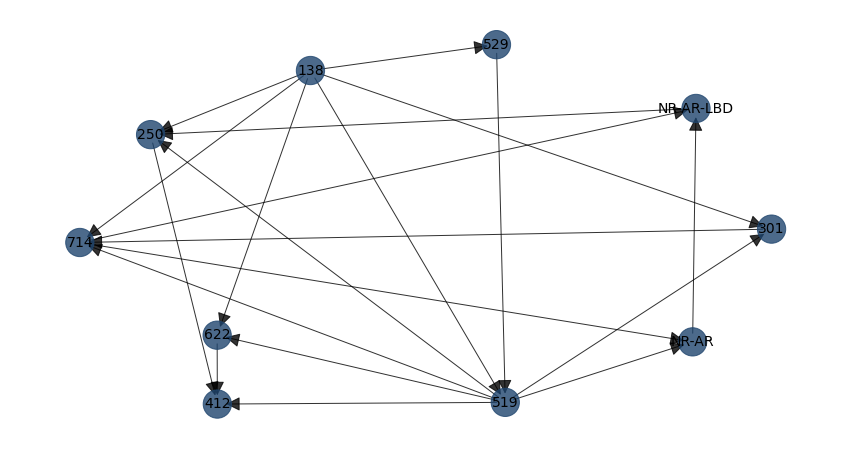

[bnlearn]> Remaining columns for inference: 8


100%|██████████| 33/33 [00:01<00:00, 25.39it/s]

 Feature no. 0
  ACC: [0.7874], mean: 0.7874
  BAC: [0.7591], mean: 0.7591
  AUC: [0.7591], mean: 0.7591
  PRE: [0.8732], mean: 0.8732
  REC: [0.5794], mean: 0.5794
  
 Feature no. 1
  ACC: [0.7598], mean: 0.7598
  BAC: [0.7345], mean: 0.7345
  AUC: [0.7345], mean: 0.7345
  PRE: [0.8451], mean: 0.8451
  REC: [0.5455], mean: 0.5455
  


In [ ]:
for feature in features_tox:
  if feature in used_params: 
    used_params.remove(feature)
X_test_prep = X_test.loc[:, map(int, used_params)]
X_test_prep.columns = used_params

G = bn.plot(DAGp) #plot

Pout = bn.predict(DAGp, X_test_prep, variables=features_tox)
y_pred = Pout[features_tox]

acc, bac, auc, pre, rec = [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox), [None]*len(features_tox)
for i, _ in enumerate(features_tox):
  acc[i], bac[i], auc[i], pre[i], rec[i] = [], [], [], [], []
  acc[i].append(round(accuracy_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  bac[i].append(round(balanced_accuracy_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  auc[i].append(round(roc_auc_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  pre[i].append(round(precision_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
  rec[i].append(round(recall_score(y_test[features_tox[i]].astype(int), y_pred[features_tox[i]]), 4))
for i, (c,b,a,p,r) in enumerate(zip(acc, bac, auc, pre, rec)): 
  print(f''' Feature no. {i}
  ACC: {c}, mean: {round(mean(c), 4)}
  BAC: {b}, mean: {round(mean(b), 4)}
  AUC: {a}, mean: {round(mean(a), 4)}
  PRE: {p}, mean: {round(mean(p), 4)}
  REC: {r}, mean: {round(mean(r), 4)}
  ''')

In [ ]:
G = bn.plot(DAGp, interactive=True) #plot

[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


In [ ]:
# y_test.index = Pout.index
# comp = pd.concat([Pout, y_test], axis=1)
# comp.columns = [f'Predicted', 'p', f'Active']

# preds, probs, actus = [], [], []
# for _, row in comp.iterrows():
#   if row['Predicted'] != int(row['Active']):
#     preds.append(row['Predicted'])
#     probs.append(row['p'])
#     actus.append(row['Active'])
# preds_sum = pd.DataFrame(data={'Predicted': preds, 'p': probs, 'Active': actus}).sort_values('p')
# preds_sum.reset_index(inplace=True)
# print(preds_sum.to_string())